In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

# Template: Plot metrics, poke the model 

This file provides a template of how to look at all the metrics of a model. The functions here can be used **while the model is still training**. If it works on your computer, you can use `%matplotlib interactive` to pan the figures in the browser.

To use it, it is advised to first **copy** the notebook to something else specific to your experiment, and leave this template alone.

In [2]:
# Locate the samples and metrics' meta data in disk.

log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/114")
samples = h5py.File(log_dir/"samples.pt", "r", swmr=True)
metrics = h5py.File(log_dir/"metrics.h5", "r", swmr=True)
metrics.keys()

<KeysViewHDF5 ['acc', 'acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'test', 'timestamps', 'total_energy']>

## Plot metrics

In [3]:
mask = (metrics['acceptance/is_sample'][:] == 1)
np.where(mask)
# This is where the samples have been taken (and accepted or rejected:)

(array([    0,  1800,  3600,  5400,  7200,  9000, 10800, 12600, 14400,
        16200, 18000, 19800, 21600, 23400, 25200, 27000, 28800, 30600,
        32400, 34200, 36000]),)

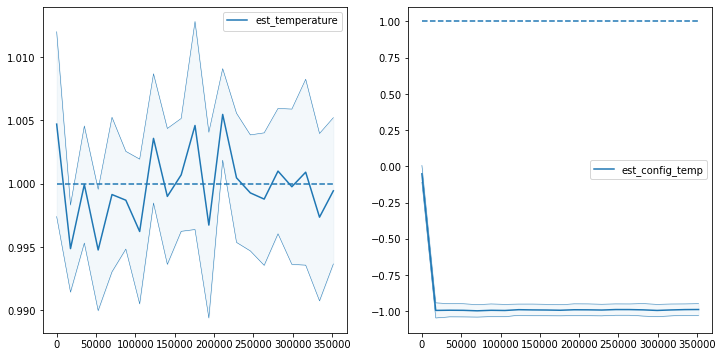

In [4]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))

plot.temperature_stderr(axes[0], metrics, "est_temperature", samples, mask=mask)
plot.temperature_stderr(axes[1], metrics, "est_config_temp", samples, mask=mask)

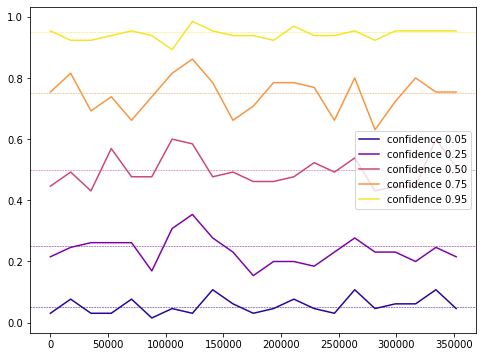

In [5]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))

plot.kinetic_temperature_intervals(ax, metrics, samples, mask=mask)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

plot.metric(axes[0, 0], metrics, 'potential', iqr_ylim=2.)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2.)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2.)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss')
plot.metric(axes[0, 2], metrics, 'test/loss', mask=test_mask)

for k in metrics["preconditioner"].keys():
    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, test_mask, legend=False)

plot.metric(axes[1, 1], metrics, 'lr')

plot.metric(axes[1, 2], metrics, 'acc')
plot.metric(axes[1, 2], metrics, 'test/acc', mask=test_mask)

## Load and poke the model

In [7]:
with open(log_dir/"config.json", "r") as f:
    config = json.load(f)
config["model"]

'googleresnet'

In [8]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)

del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

In [9]:
device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                                "model",
                                "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                                "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                                "weight_prior_params", "bias_prior_params"))})